In [20]:
import matplotlib.pyplot as plt
import json
import os
import numpy as np
from matplotlib.pyplot import figure
import glob

In [21]:
dataset_metadata = { 'yelp': {"train_size": 30400, "val_size": 3800, 'metric': 'acc', 'coverage': 0.83}, 
                     'imdb': {"train_size": 20000, "val_size": 2500, 'metric': 'acc', 'coverage': 0.88},
                     'trec': {"train_size": 4800, "val_size": 500, 'metric': 'acc', 'coverage': 0.95},
                     'youtube': {"train_size": 2000, "val_size": 120, 'metric': 'acc', 'coverage': 0.87},
                     'chemprot': {"train_size": 12600, "val_size": 1607, 'metric': 'acc', 'coverage': 0.86},
                     'spouse': {"train_size": 22254, "val_size": 2811, 'metric': 'f1_binary', 'coverage': 0.25 },
                     'cdr': {"train_size": 8430, "val_size": 920, 'metric': 'f1_binary', 'coverage': 0.907 }
                   }
result_directory = "results"
datasets = ['youtube', 'trec', 'cdr', 'chemprot', 'imdb', 'spouse', 'yelp']
N_RUNS = 5
PERCENT_TRIAL = 5
label_models = ['majority_voting', 'snorkel', 'val_as_train', 'dawid_skene', 'flying_squid']
end_models = ['mlp', 'bert']
LM_to_color = { 'majority_voting': 'blue', 
                'snorkel': 'orange',
                'val_as_train': 'black',
                'generative_model': 'green',
                'flying_squid': 'red',
                'dawid_skene': 'purple'}
EM_to_color = {'mlp_model' : 'grey',
                'bert_classifier_model' : 'yellow'}


## Investigation 1: Validation Set Sizes

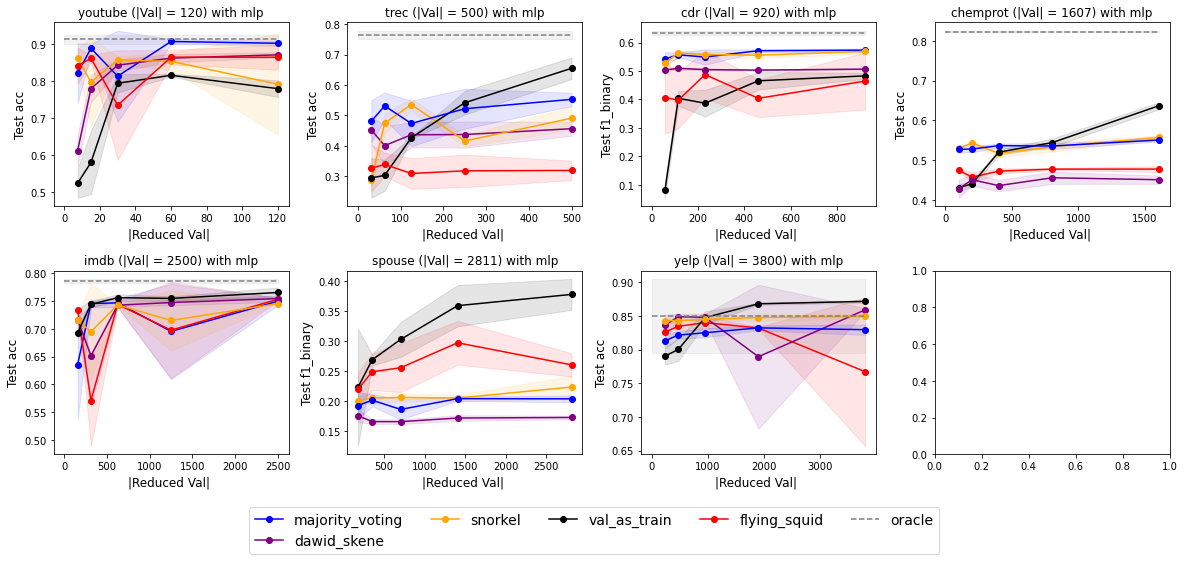

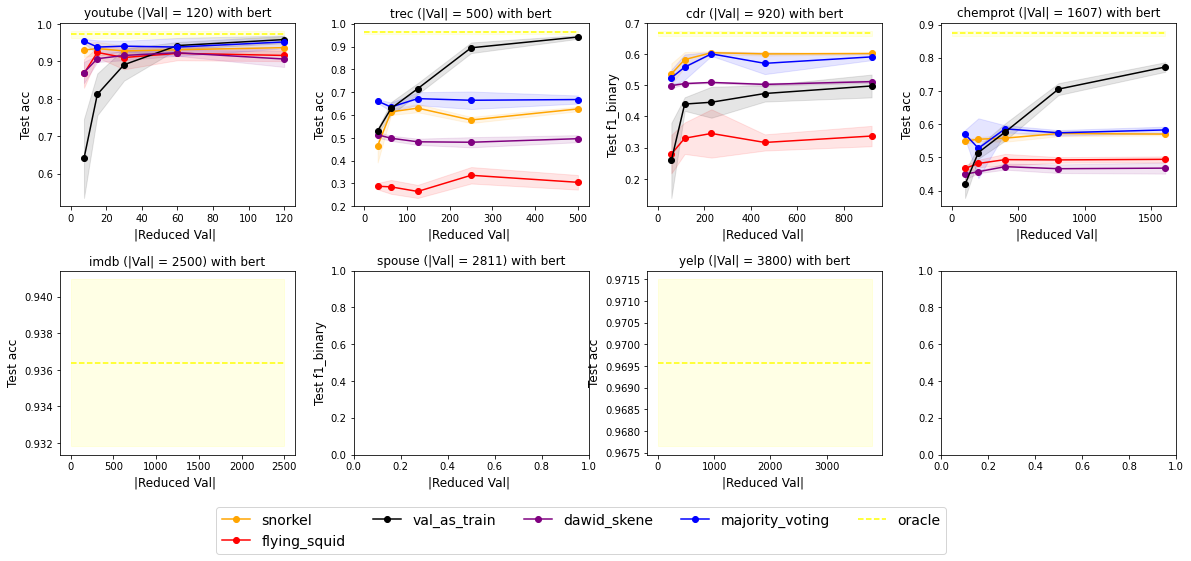

In [28]:
for end_model in end_models:
    fig, axs = plt.subplots(2, 4, figsize=(20,8))
    counter_x = 0
    counter_y = 0
    for data in datasets:
        files_per_data = glob.glob(f'{result_directory}/{data}*.json')
        old_files_per_data = glob.glob(f'results_old/old-{data}*.json')
        
        ax = axs[counter_y, counter_x]

        counter_x += 1
        if counter_x == 4:
            counter_x = 0
            counter_y += 1
        for filepath in old_files_per_data:
            new_filepath = filepath.replace("results_old/old-", result_directory+"/")
            if new_filepath in files_per_data:
                filepath = new_filepath
            with open(filepath) as f:
                file =  filepath.split("/")[1].split('.')[0].split("-")
                if file[0] == "old":
                    file.remove("old")
                dataset_name, pip ,LM, EM = file
                if LM not in label_models or not EM.lower().startswith(end_model):
                    continue
                result_dict = json.load(f)
                x = result_dict.keys()
                # lm_test = [result_dict[k]["lm_test"] for  k in result_dict]
                em_test = [result_dict[k]["em_test"] for  k in result_dict]
                # lm_test_mean, lm_test_std = zip(*[list(v.values())[0] for v in lm_test])
                em_test_mean, em_test_std = zip(*[list(v.values())[0] for v in em_test])
                em_test_se = np.array(em_test_std) / np.sqrt(N_RUNS)
                x = np.array(list(x)).astype(float) * dataset_metadata[data]['val_size']
                if pip == "val_as_train":
                    ax.plot(x, em_test_mean, label = pip, color = LM_to_color[pip], marker='o')
                    ax.fill_between(x, em_test_mean  - 1.96* em_test_se, em_test_mean + 1.96* np.array(em_test_se), alpha=0.1, color = LM_to_color[pip])
                else:
                    ax.plot(x, em_test_mean, label = LM, color = LM_to_color[LM], marker='o')
                    ax.fill_between(x, em_test_mean  - 1.96* em_test_se, em_test_mean + 1.96* np.array(em_test_se), alpha=0.1, color = LM_to_color[LM])
        for filepath in files_per_data:
            with open(filepath) as f:
                file =  filepath.split("/")[1].split('.')[0].split("-")
                dataset_name, pip ,LM, EM = file
                if LM not in label_models or not EM.lower().startswith(end_model) or pip != "oracle":
                    continue
                result_dict = json.load(f)
                x = result_dict.keys()
                em_test_mean, em_test_std = list(result_dict["em_test"].values())[0]
                em_test_mean = np.repeat(em_test_mean, PERCENT_TRIAL)
                em_test_se = np.repeat(em_test_std, PERCENT_TRIAL) / np.sqrt(N_RUNS)
                x = np.linspace(0, dataset_metadata[data]['val_size'], PERCENT_TRIAL)
                ax.plot(x, em_test_mean, label =pip, color = EM_to_color[EM], linestyle='dashed')
                ax.fill_between(x, em_test_mean  - 1.96* em_test_se, em_test_mean + 1.96* np.array(em_test_se), alpha=0.1, color = EM_to_color[EM])
        ax.set_title(f"{dataset_name} (|Val| = {dataset_metadata[dataset_name]['val_size']}) with {end_model}", fontsize=12)
        ax.set_xlabel("|Reduced Val| ", fontsize=12)
        ax.set_ylabel("Test {}".format(dataset_metadata[data]['metric']), fontsize=12)
        if counter_x == 1 and counter_y == 0:
            ax.legend(ncol=5, bbox_to_anchor=(3.8, -1.60), fontsize = 14)
    plt.subplots_adjust(bottom=0.25, top=1.0, hspace=0.35, wspace=0.25)
    plt.savefig(end_model+".png")